# Import software libraries and load the dataset #

In [1]:
import sys                             # Read system parameters.
import numpy as np                     # Work with multi-dimensional arrays and matrices.
import pandas as pd                    # Manipulate and analyze data.
import matplotlib as mpl               # Create 2D charts.
import matplotlib.pyplot as plt
import seaborn as sb                   # Perform data visualization.
import sklearn                         # Perform data mining and analysis.
from sklearn import datasets

# Summarize software libraries used.
print('Libraries used in this project:')
print('- Python {}'.format(sys.version))
print('- NumPy {}'.format(np.__version__))
print('- pandas {}'.format(pd.__version__))
print('- Matplotlib {}'.format(mpl.__version__))
print('- scikit-learn {}\n'.format(sklearn.__version__))

# Load the dataset.
boston = datasets.load_boston()
print('Loaded {} records.'.format(len(boston.data)))

# Convert array to pandas DataFrame.
data_raw = pd.DataFrame(boston['data'], columns = boston['feature_names'])
data_raw['target'] = boston['target']

Libraries used in this project:
- Python 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
[GCC 7.3.0]
- NumPy 1.16.2
- pandas 0.24.2
- Matplotlib 3.0.3
- scikit-learn 0.20.3

Loaded 506 records.


# Drop columns that won't be used for training

In [2]:
# Drop column from dataset that shows weak correlation.
def drop_unused(dataset):
    
    print('Columns before drop:\n\n{}\n'.format(list(dataset.columns)))
        
    dataset = dataset.drop(['CHAS'], axis = 1)
    
    print('Columns after drop:\n\n{}\n'.format(list(dataset.columns)))
    return dataset

data_raw = drop_unused(data_raw.copy())

Columns before drop:

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'target']

Columns after drop:

['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'target']



# Identify outliers

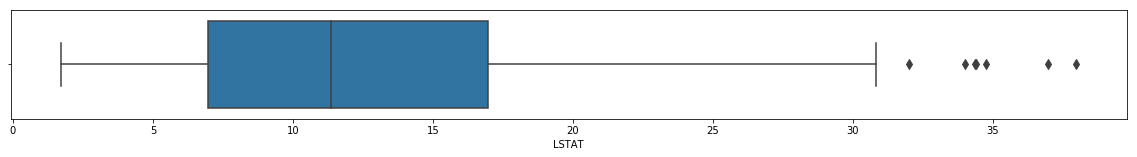

In [3]:
plt.figure(figsize = (20, 2))
bplot = sb.boxplot(x = 'LSTAT', data = data_raw, orient = 'h', fliersize = 7)

# Reduce the dimensionality of the dataset

In [4]:
X = boston['data'][:, [12]]  # Only use one feature (LSTAT).
y = boston['target']

print('Dataset dimensionality reduced.')

Dataset dimensionality reduced.


# Examine a scatter plot of `LSTAT` and `MEDV`

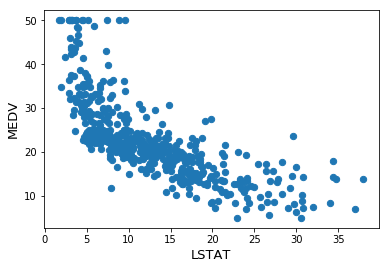

In [5]:
plt.scatter(X, y, s = 40)
    
plt.xlabel("LSTAT", fontsize = 13)
plt.ylabel("MEDV", fontsize = 13);

# Plot a regression line for a given model

In [6]:
def plot_regression(X, y, model, is_svm):
    plt.scatter(X, y, s = 40)
    plt.xlabel("LSTAT", fontsize = 13)
    plt.ylabel("MEDV", fontsize = 13)
    
    predict = model.predict(X)
    
    if is_svm == True:
        # Calculate margins based on epsilon value.
        high_margin = predict + model.epsilon
        low_margin = predict - model.epsilon
    
        # Sort arrays for plotting.
        X_sort, predict_sort, high_margin_sort, low_margin_sort = \
        zip(*sorted(zip(X, predict, high_margin, low_margin)))
    
        plt.plot(X_sort, predict_sort, c = 'r', linestyle = '-')  # Plot regression line.
        plt.plot(X_sort, high_margin_sort, c = 'r', linestyle = '--')  # Plot upper margin.
        plt.plot(X_sort, low_margin_sort, c = 'r', linestyle = '--')  # Plot lower margin.
        
        # Plot support vectors.
        plt.scatter(X[model.support_], y[model.support_],
                    s = 100, linewidth = 1, facecolors = 'none', edgecolors = 'k')
        
    else:
        X_sort, predict_sort = \
        zip(*sorted(zip(X, predict)))
        
        plt.plot(X_sort, predict_sort, c = 'r', linestyle = '-')
    
    plt.show()
    
print('Function to plot the regression line has been defined.')

Function to plot the regression line has been defined.


# Train a basic linear regression model and plot its line of best fit

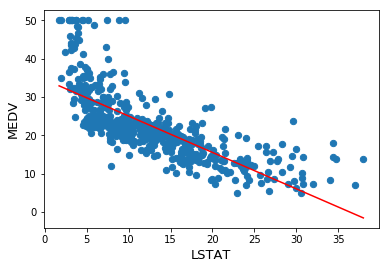

In [7]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y);

plot_regression(X, y, lin_reg, False)

# Train an SVM model and plot its regression line plus margins

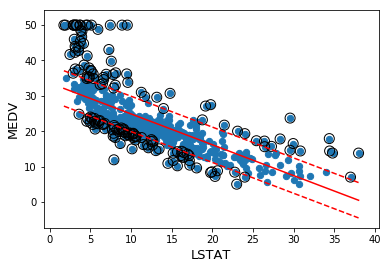

In [8]:
from sklearn.svm import SVR

svm = SVR(kernel = 'linear', epsilon = 5)
svm.fit(X, y)

plot_regression(X, y, svm, True)

# Adjust the margins using a different `epsilon` value

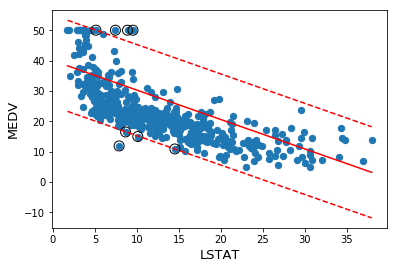

In [9]:
svm = SVR(kernel = 'linear', epsilon = 15)
svm.fit(X, y)

plot_regression(X, y, svm, True)

# Split the datasets

In [10]:
from sklearn.model_selection import train_test_split

label_columns = ['target']

# Split the training and test datasets and their labels.
X_train, X_test, y_train, y_test = train_test_split(data_raw.loc[:, 'CRIM': 'LSTAT'],
                                                                            data_raw[label_columns],
                                                                            random_state = 2)

print('Training and test datasets and their labels have been split.')

Training and test datasets and their labels have been split.


# Standardize the features

In [11]:
def standardize(X):
    result = X.copy()
    
    for feature in X.columns:
        result[feature] = (X[feature] - X[feature].mean()) / X[feature].std()  # z-score formula.
        
    return result

X_train = standardize(X_train)
X_test = standardize(X_test)

print('The features have been standardized.')

The features have been standardized.


# Evaluate an SVM model using a holdout test set

In [12]:
from sklearn.metrics import mean_squared_error as mse

svm = SVR(kernel = 'linear', epsilon = 5)
svm.fit(X_train, np.ravel(y_train))

predict = svm.predict(X_test)

# Calculate cost using the test data.
cost = mse(y_test, predict)

print('Cost (mean squared error): {:.2f}'.format(cost))

Cost (mean squared error): 21.17


# Optimize the SVM model with grid search and cross-validation

In [13]:
from sklearn.model_selection import GridSearchCV

svm = SVR(gamma = 'auto')

grid = [{'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
         'C': [0.01, 0.1, 1, 5, 10, 25, 50, 100],
         'epsilon': [0.01, 0.1, 1, 5, 10, 25, 50, 100]}]

search = GridSearchCV(svm, param_grid = grid, scoring = 'neg_mean_squared_error', cv = 5, iid = False)
search.fit(X_train, np.ravel(y_train));

print(search.best_params_)

{'C': 100, 'epsilon': 1, 'kernel': 'rbf'}


In [14]:
predict = search.predict(X_test)

cost = mse(y_test, predict)

print('Cost (mean squared error): {:.2f}'.format(cost))

Cost (mean squared error): 8.15
